In [33]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return 3*x**2 - 4*x + 5

In [6]:
f(3.0)

20.0

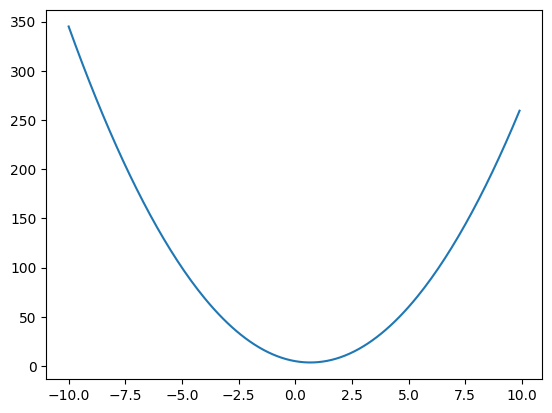

In [ ]:
xs = np.arange(-10, 10, 0.1)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

In [13]:
h = 0.00001
x = 3.0
f(x + h), f(x), (f(x + h) - f(x)) / h

(20.0001400003, 20.0, 14.00003000000538)

In [14]:
h = 0.00001
x = -3.0
f(x + h), f(x), (f(x + h) - f(x)) / h

(43.9997800003, 44.0, -21.999970000052823)

In [15]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
h = 0.0001

# inputs    
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a+=h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [142]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self._backward = lambda: None
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):

        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            other.grad += 1.0 * out.grad
            self.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            other.grad += self.data * out.grad
            self.grad +=  other.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def __truediv__(self, other):
        return self * (other**-1)

    def __pow__(self,other):
        assert isinstance(other, (int,float))
        out = Value(self.data**other, (self, ), f"**{other}")
        
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def __neg__(self):
        return self * -1

    def __sub__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        return self + (-other)
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [143]:
a = Value(2.0)
b = Value(4.0)

a - b

Value(data=-2.0)

In [82]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir' : "LR"})# слева направо
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | = %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [144]:
# пример нейрона
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813, label = 'b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

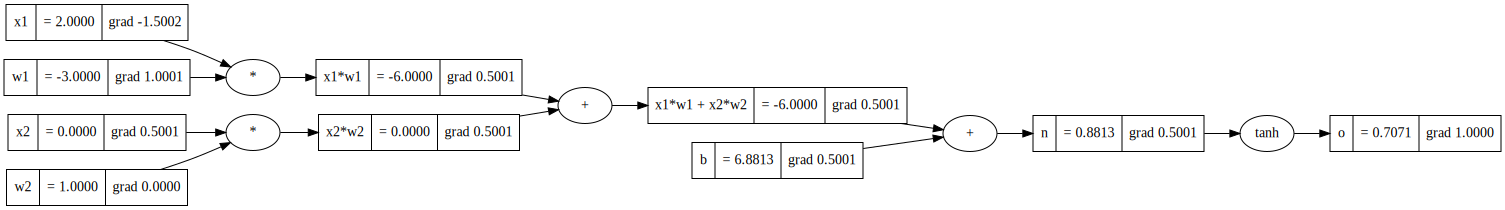

In [145]:
draw_dot(o)

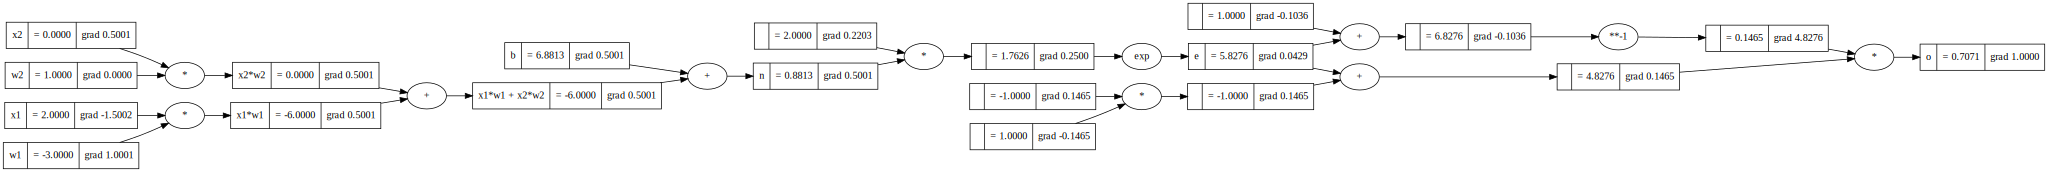

In [146]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813, label = 'b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e-1) / (e + 1); o.label = 'o'

o.backward()

draw_dot(o)

#### теперь то же самое но в торче

In [147]:
import torch

In [156]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7070699720278941
----
x1 -1.5001561639694192
x2 0.5000520546564731
w1 1.0001041093129461
w2 0.0
